In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewnorm
from itertools import islice
import time
import copy
vec1 = pd.read_csv('demog_vectors.csv')
%pip install -upgrade ipywidgets
clear_output()
#update

### Selfish Village Model V1, V2, V3   
Rules:  
1. Randomizing initial family sizes distribution.  
2. Randomizing / unifying initial land capacities.  
3. Allow splitting and generating new families.  
4. Migration: To pick available land on their own / pick new lands by cooperation.  
5. Set each farmer's support ability.  
6. Each family farm one land.  
  
Equation:  
1. Population change: Leslie Matrix.  
2. Carry Capacity Change: $ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$  

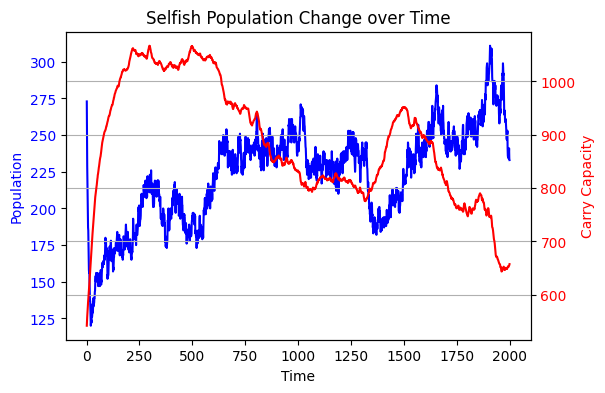

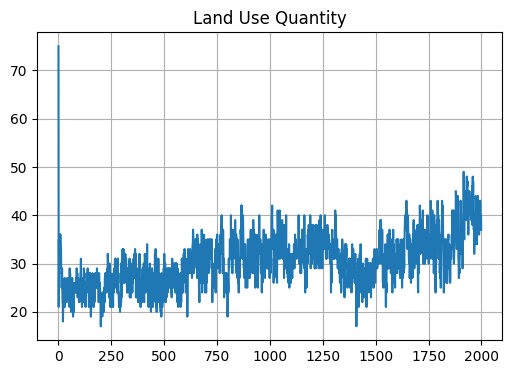

In [2]:
def selfish_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration):
    def family_num(max_size_family, num_household): # Piosson distribution (the mean is lambda)
        nums = np.random.poisson((max_size_family/2), num_household)
        nums = np.clip(nums, 1, max_size_family)
        return nums
    
    if inital_capacity == 'different':
        def carry_capacity(K_star_t, initial_lands):  
            nums = np.random.poisson((K_star_t/4), initial_lands)
            nums = np.clip(nums, 1, K_star_t)
            return nums
    if inital_capacity == 'unify':
        def carry_capacity(K_star_t, initial_lands):
            nums = np.full(initial_lands, K_star_t)
            return nums

    def calculate_effectiveness_and_consumption(population_vector, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        max_lands = np.sum(population_vector * phi) 
        consumption = np.sum(population_vector * rho)
        return round(max_lands), consumption

    np.random.seed(42)
    def generate_left_skewed_weights(num_elements):
        a = 0  # skewness
        loc = 70  # location
        scale = 60  # scale
        z = (np.arange(num_elements) - loc) / scale
        pdf = 2 * stats.norm.pdf(z) * stats.norm.cdf(a * z)
        return pdf
    initial_fam_sizes = family_num(max_size_family, num_household) 

    num_p0_rows = vec1.shape[0]
    family_demands = {} 
    age_proportions = generate_left_skewed_weights(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    family_demands = {}
    family_demands[0] = {}
    for idx, size in enumerate(initial_fam_sizes):  ###### change 
        population_vector = np.random.multinomial(size, age_proportions)       
        max_lands, consumption = calculate_effectiveness_and_consumption(population_vector, vec1)
        family_demands[0][idx] = {'family_number': idx, 'family_matrix': population_vector, 'demands': consumption, 'land_number': None} 

    def update_population_vector(population_vector, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z) #sometimes p0[i] is None??
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        for i in reversed(range(1, N)):
            if p0[i] is None or np.isnan(p0[i]) or p0[i] < 0 or p0[i] > 1:
                num_survived = 0  # handle invalid probability
            else:
                num_survived = np.random.binomial(population_vector[i-1], p0[i])
            population_vector[i] = num_survived
        fertility = 0
        m0_clipped = np.clip(m0, 0, 1)
        for j in range(len(m0_clipped)):
            if np.isnan(m0_clipped[j]):
                m0_clipped[j] = 0  # Replace NaN with 0 (or any other value you prefer)
            fertility += np.random.binomial(population_vector[j], m0_clipped[j]) ##
        population_vector[0] = fertility
        return population_vector

    t = 0
    #updating storage    
    populations = [sum(initial_fam_sizes)]  # store population values over time
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = carry_capacity(K_star_t, initial_lands)
    K_values = [] # land carry capacity  
    
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    def land_assign(land_assignments, family_demands): 
        land_numbers = list(land_assignments[0].keys())  # Get the list of available land numbers
        for family_number, demands_dict in family_demands[t].items():
            if land_numbers:
                land_number = land_numbers.pop(0)  # Take the first available land number
                demands_dict['land_number'] = land_number
                demands_dict['land_capacity'] = land_assignments[t][land_number]['carry_capacity']
            else:
                demands_dict['land_number'] = None
                demands_dict['land_capacity'] = 0
        return family_demands
    
    land_assign(land_assignments, family_demands) # lands are assigned randomly for the first year.

    if migration == 'cooperation':
        def migration(land_assignments, t, max_lands, family_demands): ### For the next variation, change it to more selfish model.
            sorted_land_assignments = sorted(land_assignments[t].items(), key=lambda item: item[1]['carry_capacity'], reverse=True)
            sorted_family_demands = sorted(family_demands[t].items(), key=lambda item: item[1]['demands'], reverse=True)  
            for idx, (family_number, demands_dict) in enumerate(sorted_family_demands):
                if idx < len(sorted_land_assignments):
                    land_number = sorted_land_assignments[idx][0]
                    land_capacity = sorted_land_assignments[idx][1]['carry_capacity']
                    demands_dict['land_number'] = land_number
                    demands_dict['land_capacity'] = land_capacity
                else:
                    demands_dict['land_number'] = None
                    demands_dict['land_capacity'] = 0
            return sorted_land_assignments, sorted_family_demands
    
    if migration =='selfish':
        def migration(land_assignments, t, max_lands, family_demands):
            free_lands = [(land_assignments[t][i]['land_number'], land_assignments[t][i]['carry_capacity']) for i in range(initial_lands) if land_assignments[t][i]['usage'] == 0]
            sorted_free_lands = sorted(free_lands, key=lambda x: x[1])
            for idx, demands_dict in family_demands[t].items():
                land_number = demands_dict['land_number']
                for idx, assignment in land_assignments[t].items():
                    if assignment['land_number'] == land_number:
                        land_capacity = assignment['carry_capacity']
                        break
                if demands_dict['demands'] * 1.5 > land_capacity:
                    for land_number, carry_capacity in sorted_free_lands:
                        if carry_capacity >= demands_dict['demands']:
                            demands_dict['land_number'] = land_number
                            break
                        else: pass
            return family_demands

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated
        family_demands[t] = copy.deepcopy(family_demands[t-1])
        free_lands = [land_assignments[t-1][i]['land_number'] for i in range(initial_lands) if land_assignments[t-1][i]['usage'] == 0] # available lands from last year
        families_to_add = {}  # Temporary dictionary to store new families
        families_to_delete = set()
        for family_id, family_info in family_demands[t].items():
        ########################## old year ##########################
            land_number = family_info['land_number']
            demands = family_info['demands']
            P = land_assignments[t-1][land_number]['carry_capacity']
            if split == 'split':
                ################## spliting to new families ###################
                if demands > 5 and len(free_lands) != 0:
                    new_family_id = max(max(family_demands[year].keys(), default=0) for year in range(0, t + 1)) + 1
                    new_family_info = {
                        'family_number': new_family_id,
                        'family_matrix': [0] * len(family_info['family_matrix']),  # Initialize new family's matrix
                        'demands': 0,  # to be calculated 
                        'land_number': free_lands.pop(-1) # to be assigned 
                    }
                    while demands > 5:
                        position = 0
                        while family_info['family_matrix'][position] == 0:
                            position = random.choice(range(len(family_info['family_matrix'])))
                        family_info['family_matrix'][position] -= 1
                        demands -= np.sum(vec1.rho[position] * 1)
                        new_family_info['family_matrix'][position] += 1
                    rho = vec1.rho
                    new_family_info['demands'] = np.sum(new_family_info['family_matrix'] * rho)
                    # family_demands[t][new_family_id] = new_family_info
                    families_to_add[new_family_id] = new_family_info  # Store new family temporarily
                    ################## spliting to new families ###################
            
            support = num_support * np.sum(family_info['family_matrix'][15:49])
            food = min(P, support) # Food they produced and feed people at the end of last year.
            z = food / demands 
            ########################## new year ##########################
            population_vector = update_population_vector(family_info['family_matrix'], vec1, z)
            population_vector = np.array(population_vector)
            population_vector[np.isnan(population_vector)] = 0
            family_info['family_matrix'] = population_vector
            max_lands, consumption = calculate_effectiveness_and_consumption(family_info['family_matrix'], vec1)
            family_info['demands'] = consumption
            if consumption == 0 or max_lands == 0: ## can drop max_lands
                families_to_delete.add(family_info['family_number'])
        if split == 'split':
            family_demands[t].update(families_to_add)
        family_demands[t] = {family_id: family_info for family_id, family_info in family_demands[t].items() if family_id not in families_to_delete}
        ########################## farming after updating the family info ##########################
        #############################################################################################
        selected_lands = []
        for family_info in family_demands[t].values():
            land_number_value = family_info['land_number']
            selected_lands.append(land_number_value)

        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        
        # I am doing in this way because I think the land info will collide with the previous year if I'd move it up before updating the demands and etc.
        sorted_entries = sorted(family_demands[t].values(), key=lambda x: x['land_number'])
        land_number_to_demand = {entry['land_number']: entry['demands'] for entry in sorted_entries}
        K_t_demands = [land_number_to_demand.get(i, 0) for i in range(initial_lands)]
    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_demands[i] * u_t[i])) ############
        #############################################################################################
        ########################## migration ##########################
        migration(land_assignments, t, max_lands, family_demands)
        ################################################################
        sum_of_populations = []
        for family_info in family_demands[t].values():
            pop = np.sum(family_info['family_matrix'])
            sum_of_populations.append(pop)
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        populations.append(sum(sum_of_populations))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, u_values, land_assignments, family_demands
    
def plot_selfish_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration):
    populations, K, U, _, _ = selfish_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, inital_capacity, split, migration)
    time_steps = range(1, simulation_time)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Selfish Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 2000 #simulation year
num_household = 100
initial_lands = 200
num_support = 4
K_star_t = 10
max_size_family = 10 #from the beginning
plot_selfish_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support, 'different', 'split', 'selfish')

### Communism Village Model V6
Rules:  
1. Randomizing initial family sizes distribution.  
2. Randomizing initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Set each farmer's support ability.  
6. Each familiy farm one land.  
  
Equation:  
1. Population change: Leslie Matrix.  
2. Carry Capacity Change: $ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$

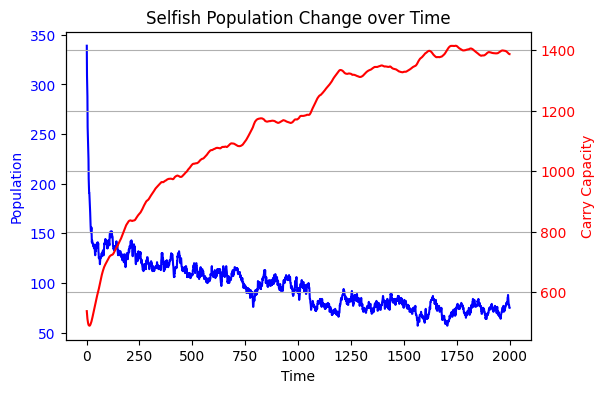

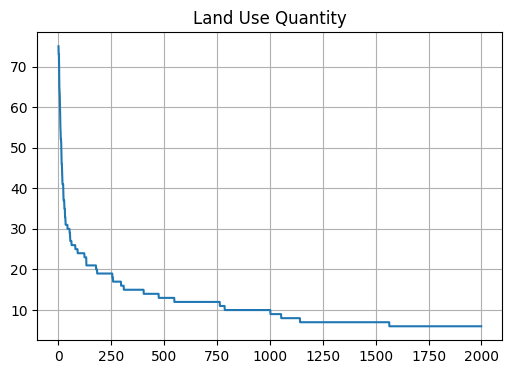

In [3]:
def communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support):
    def family_num(max_size_family, num_household): # Piosson distribution (the mean is lambda)
        nums = np.random.poisson((max_size_family/2), num_household)
        nums = np.clip(nums, 1, max_size_family)
        return nums
    
    def carry_capacity(K_star_t, initial_lands):  
        nums = np.random.poisson((K_star_t/4), initial_lands)
        nums = np.clip(nums, 1, K_star_t)
        return nums
    
    def calculate_effectiveness_and_consumption(population_vector, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        max_lands = np.sum(population_vector * phi) 
        consumption = np.sum(population_vector * rho)
        return round(max_lands), consumption

    np.random.seed(42)
    def generate_left_skewed_weights(num_elements):
        a = 0  # skewness
        loc = 70  # location
        scale = 60  # scale
        z = (np.arange(num_elements) - loc) / scale
        pdf = 2 * stats.norm.pdf(z) * stats.norm.cdf(a * z)
        return pdf
    initial_fam_sizes = family_num(max_size_family, num_household) 

    num_p0_rows = vec1.shape[0]
    family_demands = {} 
    age_proportions = generate_left_skewed_weights(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    family_demands = {}
    family_demands[0] = {}
    for idx, size in enumerate(initial_fam_sizes):  ###### change 
        population_vector = np.random.multinomial(size, age_proportions)       
        max_lands, consumption = calculate_effectiveness_and_consumption(population_vector, vec1)
        family_demands[0][idx] = {'family_number': idx, 'family_matrix': population_vector, 'demands': consumption, 'land_number': None} 

    def update_population_vector(population_vector, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        for i in reversed(range(1, N)):     # simulate survival for each individual in each age group using the Bernoulli distribution.
            num_survived = np.random.binomial(population_vector[i-1], p0[i])
            population_vector[i] = num_survived
        fertility = 0
        m0_clipped = np.clip(m0, 0, 1)
        for j in range(len(m0_clipped)):
            fertility += np.random.binomial(population_vector[j], m0_clipped[j]) ##
        population_vector[0] = fertility
        return population_vector

    t = 0
    #updating storage    
    populations = [sum(initial_fam_sizes)]  # store population values over time
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = carry_capacity(K_star_t, initial_lands)
    K_values = [] # land carry capacity  
    
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    def land_assign(land_assignments, t, max_lands, family_demands): ### For the next variation, change it to more selfish model.
        sorted_land_assignments = sorted(land_assignments[t].items(), key=lambda item: item[1]['carry_capacity'], reverse=True)
        sorted_family_demands = sorted(family_demands[t].items(), key=lambda item: item[1]['demands'], reverse=True)  
        for idx, (family_number, demands_dict) in enumerate(sorted_family_demands):
            if idx < len(sorted_land_assignments):
                land_number = sorted_land_assignments[idx][0]
                land_capacity = sorted_land_assignments[idx][1]['carry_capacity']
                demands_dict['land_number'] = land_number
                demands_dict['land_capacity'] = land_capacity
            else:
                demands_dict['land_number'] = None
                demands_dict['land_capacity'] = 0
        return sorted_land_assignments, sorted_family_demands
    land_assign(land_assignments, t, max_lands, family_demands)

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated
        family_demands[t] = copy.deepcopy(family_demands[t-1])
        families_to_delete = set()
        for family_info in family_demands[t].values():
        ########################## old year ##########################
            land_number = family_info['land_number']
            demands = family_info['demands']
            population_vector_old = family_info['family_matrix']
            P = land_assignments[t-1][land_number]['carry_capacity']
            support = num_support * np.sum(population_vector_old[15:49])
            food = min(P, support) # Food they produced and feed people at the end of last year.
            z = food / demands 
            ########################## new year ##########################
            population_vector = update_population_vector(population_vector_old, vec1, z)
            population_vector[np.isnan(population_vector)] = 0
            family_info['family_matrix'] = population_vector
            max_lands, consumption = calculate_effectiveness_and_consumption(family_info['family_matrix'], vec1)
            family_info['demands'] = consumption
            if consumption == 0 or max_lands == 0: ## can drop max_lands
                families_to_delete.add(family_info['family_number'])
        for i in families_to_delete: del family_demands[t][i]
        ########################## farming after updating the family info ##########################
        #############################################################################################
        selected_lands = []
        for family_info in family_demands[t].values():
            land_number_value = family_info['land_number']
            selected_lands.append(land_number_value)

        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        
        # I am doing in this way because I think the land info will collide with the previous year if I'd move it up before updating the demands and etc.
        sorted_entries = sorted(family_demands[t].values(), key=lambda x: x['land_number'])
        land_number_to_demand = {entry['land_number']: entry['demands'] for entry in sorted_entries}
        K_t_demands = [land_number_to_demand.get(i, 0) for i in range(initial_lands)]
    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_demands[i] * u_t[i])) ############
            # if land_assignments[t-1][i]['carry_capacity'] == 0: print(' natural land last year -- 0')
            # else: print(round(100 * (a * K_t_demands[i] * u_t[i]/ land_assignments[t-1][i]['carry_capacity']), 2), '%')
        #############################################################################################
        ########################## migration ##########################
        land_assign(land_assignments, t, max_lands, family_demands)
        ################################################################
        sum_of_populations = []
        for family_info in family_demands[t].values():
            pop = np.sum(family_info['family_matrix'])
            sum_of_populations.append(pop)
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        populations.append(sum(sum_of_populations))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, u_values, land_assignments, family_demands
    
def plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support):
    populations, K, U, _, _ = communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support)
    time_steps = range(1, simulation_time)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Selfish Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 2000 #simulation year
num_household = 100
initial_lands = 200
num_support = 4
K_star_t = 10
max_size_family = 10 #from the beginning
plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household, num_support)

### Communism Village Model V5  
Rules:  
1. Does not exist family concept yet.
2. Unifying initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Don't set each farmer's support ability.  
6. Each person farm one land.
  
Equation:  
1. Population change: Leslie Matrix.  
2. Carry Capacity Change: $ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$

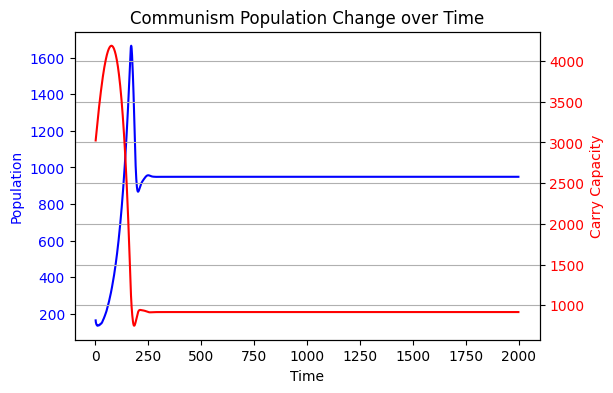

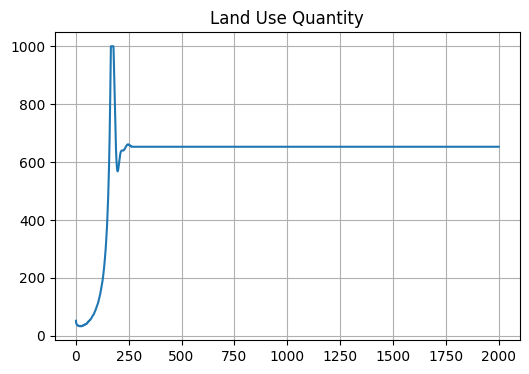

In [5]:
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, K_star_t):
    def generate_left_skewed_proportions(num_elements):
        data = skewnorm.rvs(a=-2, loc=0.4, scale=0.2, size=num_elements)
        data = data[data >= 0]
        proportions = data / np.sum(data)
        # Ensure that there are exactly num_elements proportions (padding with zeros if necessary)
        if len(proportions) < num_elements:
            proportions = np.append(proportions, [0] * (num_elements - len(proportions)))
        return proportions

    # Generate age groups and their corresponding proportions to match p0 rows in vec1
    num_p0_rows = vec1.shape[0]
    age_proportions = generate_left_skewed_proportions(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    population_matrix = initial_population * age_proportions
    
    def update_population_matrix(population_matrix, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        m1 = np.zeros([N, N])
        for i in range(N - 1):
            m1[i + 1, i] = p0[i]
        m1[0, :] = m0
        new_population_matrix = np.dot(population_matrix, m1)
        return new_population_matrix

    def calculate_effectiveness_and_consumption(population_matrix, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        max_lands = np.sum(population_matrix * phi) #### double multiple
        consumption = np.sum(population_matrix * rho)
        
        return round(max_lands), consumption
    
    #updating storage    
    populations = [initial_population]  # store population values over time
    P_values = [[0] for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }
    
    def find_top_lands(K_t_natural, max_lands, consumption):
        sorted_lands = sorted(enumerate(K_t_natural), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
        # utility_ = []
        for (land_index, utility) in sorted_lands:
            cumulative_utility += utility  ### can add to min(utility, support) later
            selected_lands.append(land_index)
            if float(cumulative_utility) >= consumption:  # Update the comparison here ###correct. the non-consistent links 
                break
            if len(selected_lands) >= max_lands:  # Update the comparison here
                break 
            else: pass
        return selected_lands, cumulative_utility

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated.
        max_lands, consumption = calculate_effectiveness_and_consumption(population_matrix, vec1)
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands, P = find_top_lands(K_t_natural, max_lands, consumption)# select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_natural[i] * u_t[i])) ############
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        z = P / consumption # food availability parameter == carry capacity in my case 
        if z == 0: z = 0.0001
        population_matrix = update_population_matrix(population_matrix, vec1, z) ### didn't update the matrix
        population_matrix[np.isnan(population_matrix)] = 0
        if P  == 0: P = 0.1
        populations.append(np.sum(population_matrix))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, P_values, u_values, land_assignments

def plot_commuism_simulation_population2(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, K_star_t):
    
    populations, K, _, U, _ = communism_simulation_population_original(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, K_star_t)
    
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Communism Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 2000 #simulation year
initial_population = 200
initial_capacity = 3
initial_lands = 1000
K_star_t = 7
plot_commuism_simulation_population2(vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, K_star_t)

### Communism Village Model V4 
Rules:  
1. Does not exist family concept yet.
2. Unifying initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Don't set each farmer's support ability.  
6. Each person farm one land.  
7. Unifying individual demand and work effectiveness apart from the age.  
8. Do not exist initial population matrix, only a population number.  
  
Equation:  
1. Population change: Leslie Matrix.  
2. Carry Capacity Change: $ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$

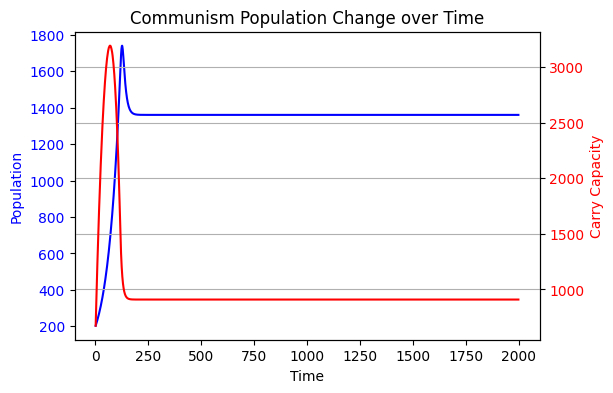

In [8]:
tmp1 = pd.DataFrame({'z': [], 'r': []})  # Initialize an empty DataFrame

def parameter_oscillation(t, a_mean, a_amplitude, oscillation_period):
    # Calculate the parameter `a` based on a sine function
    a_t = a_mean + a_amplitude * np.sin(2 * np.pi * t / oscillation_period)
    return a_t

# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):

    # Get the Leslie matrix for a given food ratio (z) using the parameters
    def get_matrix(z, vec1):
        p0 = vec1.pstar * sp.gdtr(1.0/vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0/vec1.fertscale[0], vec1.fertparm[0], z)
        N = len(p0)
        m1 = np.zeros([N,N])
        for i in range(N-1):
            m1[i+1,i] = p0[i]
        m1[0,] = m0
        return m1

    # Calculate relative population change in one year for a given food ratio
    def get_rate(z, vec1):
        m1 = get_matrix(z, vec1)
        tmp2 = sl.eigvals(m1)
        ix = tmp2.real.argmax()
        if tmp2[ix].imag != 0.0:
            raise BaseException('Invalid solution!\n')
        return tmp2[ix].real
         
    ### d is natural death rate    
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_population): 
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': i, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_population)] 
    
    ### Farming Process
        ### Define the function
        
    def find_top_lands(K_t, populations): 
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
                
        for land_index, utility in sorted_lands:
            cumulative_utility += utility
            selected_lands.append(land_index)  
            if cumulative_utility >= populations[-1]:
                break

        if len(selected_lands) > populations[-1]:
            selected_lands = selected_lands[:int(populations[-1].astype(float))] ####corrected
        else: pass
        return selected_lands
   
    ### Updating process
    K_t_list = [K_t]
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_population)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = find_top_lands(K_t, populations) # select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_population): 
                land_assignments[t][i] = {
                    'landlord': i,
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }

        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
   
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_population)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
            
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(initial_population):
            # land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, K_t_delayed[i] + k * (K_star_t - K_t_delayed[i]) - a * K_t_delayed[i] * u_t[i]))

            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * land_assignments[t-1][i]['carry_capacity'] * u_t[i])) ############
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_population)] ## list of each land cell capacity (new year, this year)

        # Calculate the Leslie matrix for the current food ratio (z)
        z = P/ N_t  # food availability parameter == carry capacity in my case 
        ### in the original code file, Y - scalar, kcal/ha/day in ag yield - it is a constant (?) only one value.
        m1 = get_matrix(z, vec1)
            
        # Apply leslie population change factors
        r = get_rate(z, vec1)  # Calculate the population change rate for the current food ratio
        tmp1 = tmp1.append({'z': z, 'r': r}, ignore_index=True)  # Append the new row to the DataFrame
        
        population_change_ = N_t * r 
        populations.append(population_change_)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        # K_t_list.append([land_assignments[t][i]['carry_capacity'] for i in range(initial_population)])
        # K_values.append(sum([land_assignments[t][i]['carry_capacity'] for i in range(initial_population)]))
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()

k = 0.01 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 2000 #simulation year
initial_population = 200
initial_capacity = 3
initial_lands = 1000
max_capacity_one_land = 50
plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)

### Communism Village Model V3 
Rules:  
1. Does not exist family concept yet.
2. Unifying initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Don't set each farmer's support ability.  
6. Each person farm one land.  
7. Unifying individual demand and work effectiveness apart from the age.  
8. Do not exist initial population matrix, only a population number was given at the beginning.  
9. <u>All the lands are utilized instead of finding top lands</u>
  
Equation:  
1. Population change:${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})- d\cdot N$  
2. Carry Capacity Change: $ K_{i}^{(t+1)} = K_{i}^{t} + c(K_{\text{max}} - K_{i}^{t}) - x_{i}aK_{i}^{t}$

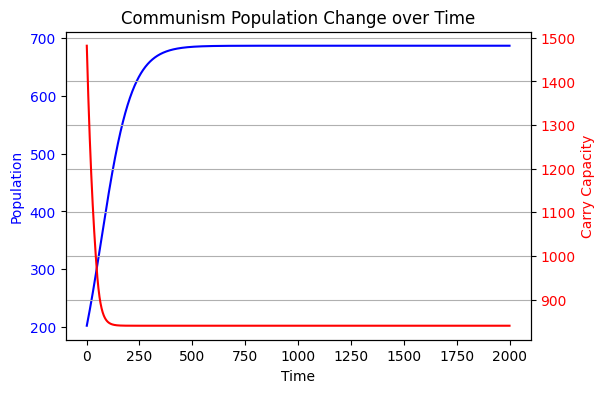

In [9]:
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land):
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): # here I changed to loop over number of lands instead of number of populations.
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': None, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }
                if i <= initial_population: land_assignments[0][i]['landlord'] = i

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_lands)] 

    ### Farming Process
        ### Define the function
    def find_top_lands(K_t, populations): #modified part, here is not the top lands, instead, all lands are utilized based on a descending order, aka, everyone farm.
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
                
        if len(sorted_lands) > populations[-1]:
            sorted_lands = sorted_lands[:int(populations[-1])] ####corrected
        else: pass
        return sorted_lands

    ### Updating process
        
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = [x[0] for x in find_top_lands(K_t, populations)]
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): 
                land_assignments[t][i] = {
                    'landlord': land_assignments[0][i]['landlord'],
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
                
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
        N_t_plus_1 = N_t + r * N_t * (1 - N_t / P) - d * N_t * Q #### update the total population # the total population of the new year (this year is the new year)
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * land_assignments[t-1][i]['carry_capacity'] * u_t[i]))
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)

        # Append the new values to the respective lists
        populations.append(N_t_plus_1)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(r, k, a, d, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()


r = 0.0135 # population birth rate
k = 0.02 # land recovery rate 
a = 0.03 # land deplation rate
d = 0.003
simulation_time = 2000 #simulation year
initial_population = 200
initial_capacity = 5
initial_lands = 300
max_capacity_one_land = 7
plot_commuism_simulation_population2(r, k, a, d, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)

### Communism Village Model V2  
Rules:  
1. Does not exist family concept yet.
2. Randamizing initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Don't set each farmer's support ability.  
6. Each person farm one land.  
7. Unifying individual demand and work effectiveness apart from the age.  
8. Do not exist initial population matrix, only a population number was given at the beginning.  
9. <u>Only top lands are utilized</u>
10. <u>Land grow and family grow are seperated</u>
11. Have death rate.  
  
Equation:  
1. Population change:${{N^{(t+1)}_i}} = {{N^{(t)}_i}} + r\cdot {{N^{(t)}_i}} (1-\frac{{N^{(t)}_i}}{{P_i}})$  
2. Carry Capacity Change: $K_i^{(t+1)} = \max \left(\min \left(K_i^*,K_i^t + k(K_i^*-K_i^t)-u_i^t\right),0\right)$

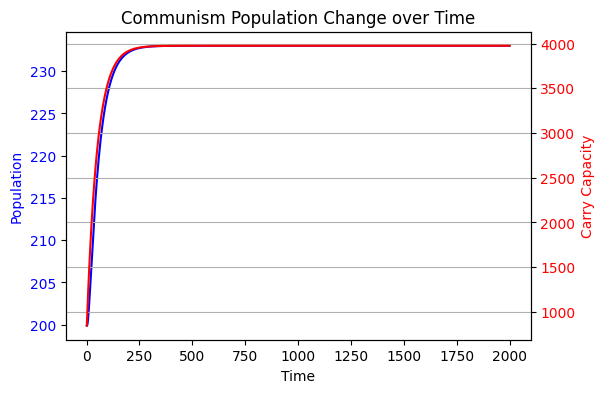

In [10]:
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(r, k, d, a, initial_population, simulation_time, max_capacity_one_land):
    ### d is natural death rate
    def carry_capacity(max_capacity_one_land, initial_population): # all starts from max
        num_lst = np.arange(1, max_capacity_one_land + 1)
        x_min = 1
        alpha = 2
        x = np.linspace(x_min, 5, max_capacity_one_land)
        probabilities = (alpha * x_min**alpha) / (x**(alpha + 1))
        num = random.choices(num_lst, weights=probabilities, k = initial_population) 
        return num
    
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = carry_capacity(max_capacity_one_land, initial_population)
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_population): 
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': i, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_population)] 
    
    ### Farming Process
        ### Define the function
    def find_top_lands(K_t, populations): 
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
                
        for land_index, utility in sorted_lands:
            cumulative_utility += utility
            selected_lands.append(land_index)  
            if cumulative_utility >= populations[-1]:
                break

        if len(selected_lands) > populations[-1]:
            selected_lands = selected_lands[:int(populations[-1].astype(float))] ####corrected
        else: pass
        return selected_lands
   
    ### Updating process
        
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_population)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = find_top_lands(K_t, populations) # select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_population): 
                land_assignments[t][i] = {
                    'landlord': i,
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }

        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_population)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
        N_t_plus_1 = N_t + r * N_t * (1 - N_t / P) - d * N_t * Q #### update the total population # the total population of the new year (this year is the new year)
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(initial_population):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * u_t[i-1]))
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_population)] ## list of each land cell capacity (new year, this year)

        # Append the new values to the respective lists
        populations.append(N_t_plus_1.astype(float))
        K_values.append(sum(K_t_plus_1).astype(float)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(r, k, a, d, initial_population, simulation_time, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, simulation_time, max_capacity_one_land)
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()


r = 0.1 # population birth rate
k = 0.02 # land recovery rate 
a = 0.04 # land deplation rate
d = 0.003
simulation_time = 2000 #simulation year
initial_population = 200
max_capacity_one_land = 20
plot_commuism_simulation_population2(r, k, a, d, initial_population, simulation_time, max_capacity_one_land)

### Communism Village Model V1
Rules:  
1. Family concept exists. Change family size based on the total population change.  
2. Randamizing initial land capacities.  
3. Don't allow splitting and generating new families.  
4. Migration: Pick new lands by cooperation each year.  
5. Don't set each farmer's support ability.  
6. Each person farm one land.  
7. Unifying individual demand and work effectiveness apart from the age.  
8. Do not exist initial population matrix, only a population number was given at the beginning.  
9. <u>Land grow and family grow are seperated</u>
10. No death rate.  
  
Equation:  
1. Population change:${{N^{(t+1)}_i}} = {{N^{(t)}_i}} + r\cdot {{N^{(t)}_i}} (1-\frac{{N^{(t)}_i}}{{P_i}})$  
2. Carry Capacity Change: $K_i^{(t+1)} = \max \left(\min \left(K_i^*,K_i^t + k(K_i^*-K_i^t)-u_i^t\right),0\right)$

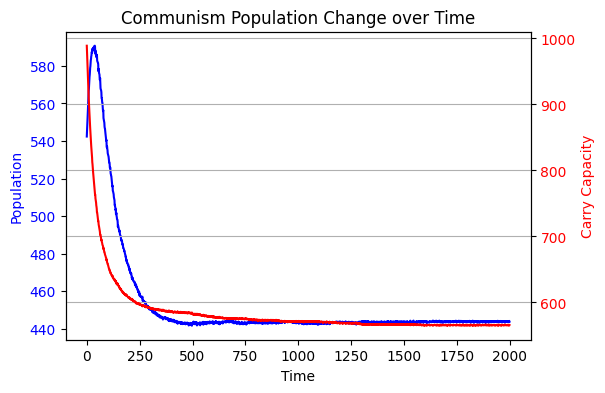

In [11]:
def communism_simulation_population(max_size_family, r, k, a, K_star, initial_land_and_family, simulation_time):
    
    def family_num(max_size_family):
        num_lst = np.arange(1, max_size_family + 1)  # Adjusted to include max_size_family
        weights = np.random.normal(0, 1, size=(max_size_family,))  # Generate weights for the entire population
        weights = np.absolute(weights)  # Ensure positive weights

        num = random.choices(num_lst, weights=weights, k=1)
        return sum(num)

    def carry_capacity(max_size_family): ####
        num_lst = np.arange(1, max_size_family + 1)  # Adjusted to include max_size_family
        weights = np.random.normal(0, 1, size=(max_size_family,))  # Generate weights for the entire population
        weights = np.absolute(weights)  # Ensure positive weights

        num = random.choices(num_lst, weights=weights, k=1)
        return sum(num)
    
    def carry_capacity2(max_size_family): #### all cells have the max capacity
        return max_size_family


    P_values = [[0] * initial_land_and_family for _ in range(simulation_time)] # total harvest capacity of the year (food)
    u_values = [[0] * initial_land_and_family for _ in range(simulation_time)] # using land or not decision
    K_values = [] #total land carry capacity
    
    land_assignments = {}  # dictionary to store land assignments
    k_values = [carry_capacity2(max_size_family) for _ in range(initial_land_and_family)] #randomly distribute the land capacity for each family in the zero year
    family = [family_num(max_size_family) for _ in range(initial_land_and_family)] #randomly distribute the family size for each family in the zero year
    initial_population = sum(family)
    populations = [initial_population]  # store population values over time

    land_assignments = {} 
    land_assignments[0] = {} # assigning land capacity to each family in the zero year
    for i in range(initial_land_and_family): 
                land_assignments[0][i+1] = {
                    'family': family[i],
                    'land': i+1, #land numbering
                    'carry_capacity': k_values[i]
                }

    ### Updating Process
    for t in range(1, simulation_time + 1): 

        land_assignments[t] = {} # adding a sub-dict in each year.
        for i in range(initial_land_and_family): 
                land_assignments[t][i+1] = {
                    'family': land_assignments[t-1][i+1]['family'],
                    'land': i+1, #land numbering
                    'carry_capacity': None
                }

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(1, initial_land_and_family + 1)] #from the land_assignment dict, get all the land capacities in the looping year.
        family_value = [land_assignments[t-1][i]['family'] for i in range(1, initial_land_and_family + 1)] #from the land_assignment dict, get all the family size in the looping year.      
        u_t = [1 if K_t[i] >= family_value[i] else 0 for i in range(initial_land_and_family)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village
        
        N_t_plus_1 = N_t + r * N_t * (1 - N_t / P) #### update the total population # the total population of the new year (this year is the new year)
        diff_pop = N_t_plus_1 - N_t #difference between original total population and the current new population

    #         updating family size 
        households = list(land_assignments[t].keys())

        if diff_pop > 0: #if the total population increases
            probabilities = [land_assignments[t-1][household]['carry_capacity'] / land_assignments[t-1][household]['family'] for household in households] # family size increase rate will be positively correlated with the land capacity/person
            extra_population = random.choices(households, probabilities, k=int(diff_pop))
            for household in extra_population: land_assignments[t][household]['family'] += 1

        if diff_pop < 0:  # if the total population decreases
            probabilities = [1 / (land_assignments[t-1][household]['carry_capacity'] / land_assignments[t-1][household]['family']) for household in households]  # family size decrease rate will be negatively correlated with the land capacity/person
            minus_population = random.choices(households, probabilities, k=int(abs(diff_pop)))
            for household in minus_population:
                if land_assignments[t][household]['family'] > 1:  # Only decrease population if there is more than one family member
                    land_assignments[t][household]['family'] -= 1


        K_star_t = K_star # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(1, initial_land_and_family + 1):
            
            max_term = max(0, land_assignments[t-1][i]['carry_capacity'] - a * u_t[i-1]) # deplation rate; adding max function to make sure the value is not negative
#             land_assignments[t][i]['carry_capacity'] = min(K_star_t, k * K_star_t + (1 - k) * max_term) # updating the land capacity of the whole; k is the land recovery rate 
            
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity']) - a * u_t[i-1]))
            
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(1, initial_land_and_family + 1)] ## list of each land cell capacity (new year, this year)

        # Append the new values to the respective lists
        populations.append(N_t_plus_1)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, land_assignments

def plot_commuism_simulation_population(max_size_family, r, k, a, K_star, initial_land_and_family, simulation_time):
    
    populations, K, _, _, data = communism_simulation_population(max_size_family, r, k, a, K_star, initial_land_and_family, simulation_time)
    time_steps = range(simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()

r = 0.0135 # population birth rate
K_star = 12 # each land capacity ceiling
k = 0.02 # land recovery rate 
a = 0.15 # land deplation rate
simulation_time = 2000 #simulation year
initial_land_and_family = 100
max_size_family = 10
plot_commuism_simulation_population(max_size_family, r, k, a, K_star, initial_land_and_family, simulation_time)